# Laboratory Session 01

Student: Alice Pagano, Alessandra Sabatti

In [9]:
# Import main packages 
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import bokeh.palettes as palette # For palette of colors
import time
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os

#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
### for Palatino and other serif fonts use:
##rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True) 

### Load data

In [10]:
# Import experimental Bulk Dielectric Function for Au 
path      = "data1/optical_absorbance_data/Au_dielectric_bulk.txt"
cols      = pd.read_csv(path, sep="\s+", nrows=1, header=None).iloc[0].values[0:]
diel_data = pd.read_csv(path,sep="\s+",skiprows=1,header=None,names=cols)

# Import experimental result of absorbance for HAuCl4
path      = "data1/optical_absorbance_data/HAuCl4_solution.txt"
cols      = pd.read_csv(path, sep="\s+", skiprows=18,nrows=1, header=None).iloc[0].values[0:]
acid_data = pd.read_csv(path,sep="\s+",skiprows=19,header=None,names=cols)

# Import experimental result of absorbance for Au Nps
path      = "data1/optical_absorbance_data/Au_NP.txt"
cols      = pd.read_csv(path, sep="\s+", skiprows=18,nrows=1, header=None).iloc[0].values[0:]
np_data   = pd.read_csv(path,sep="\s+",skiprows=19,header=None,names=cols)

np_data

,lam(nm),abs
0,900.0,0.011796
1,899.0,0.010689
2,898.0,0.010659
3,897.0,0.010907
4,896.0,0.010460
...,...,...
546,354.0,0.636194
547,353.0,0.636754
548,352.0,0.637178
549,351.0,0.637707


In [11]:
# Reorder dielectric data in descending order
diel_data = diel_data.sort_values('lam(nm)',ascending=False)
# Convert column of lambda to float 
diel_data['lam(nm)'] = diel_data['lam(nm)'].astype(float)

# Filtered for the same wavelength that are inside np_data
diel_data = diel_data[ diel_data['lam(nm)']>=min(np_data['lam(nm)'])]


new_dataframe = {'lam(nm)' : np.array(np_data['lam(nm)']),
                 'abs'     : np.array(np_data['abs']),
                 'eps1'    : np.array(diel_data['eps1']),
                 'eps2'    : np.array(diel_data['eps2'])}
np_data = pd.DataFrame(new_dataframe) 

### Plot results of data

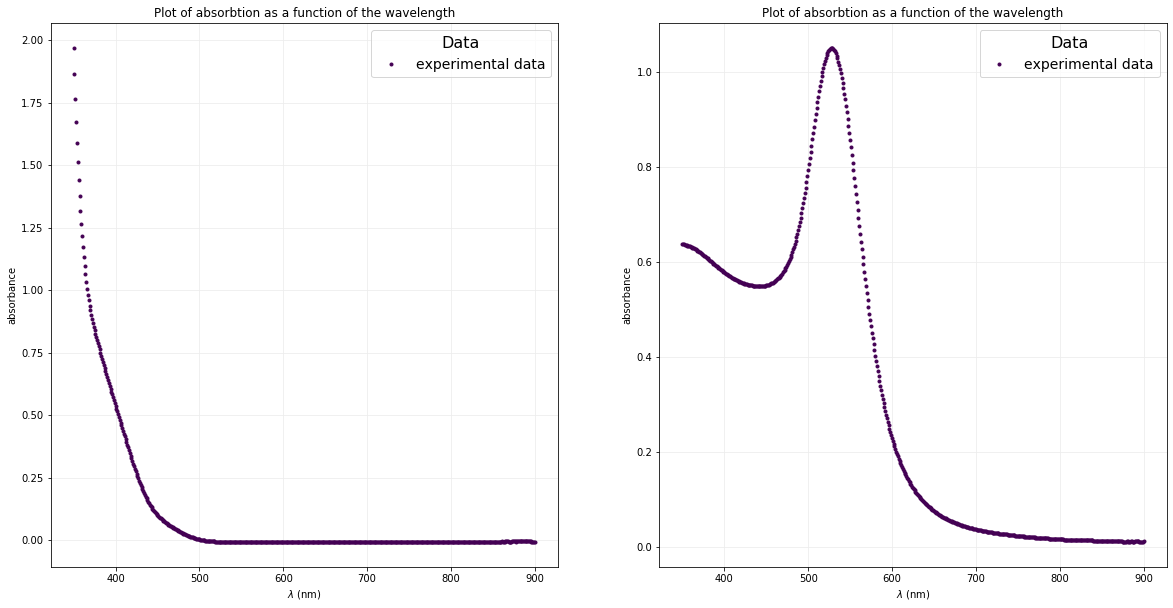

In [4]:
# Plot of experimental results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.plot(acid_data['lam(nm)'],acid_data['abs'],'.',color='#440154',label='experimental data')
ax1.set_title('Plot of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')
ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='upper right')

ax2.plot(np_data['lam(nm)'],np_data['abs'],'.',color='#440154',label='experimental data')
ax2.set_title('Plot of absorbtion as a function of the wavelength')
ax2.set_xlabel('$\lambda$ (nm)')
ax2.set_ylabel('absorbance')
ax2.grid(color='0.93')
ax2.legend(title='Data',fontsize=14,title_fontsize=16,loc='upper right')

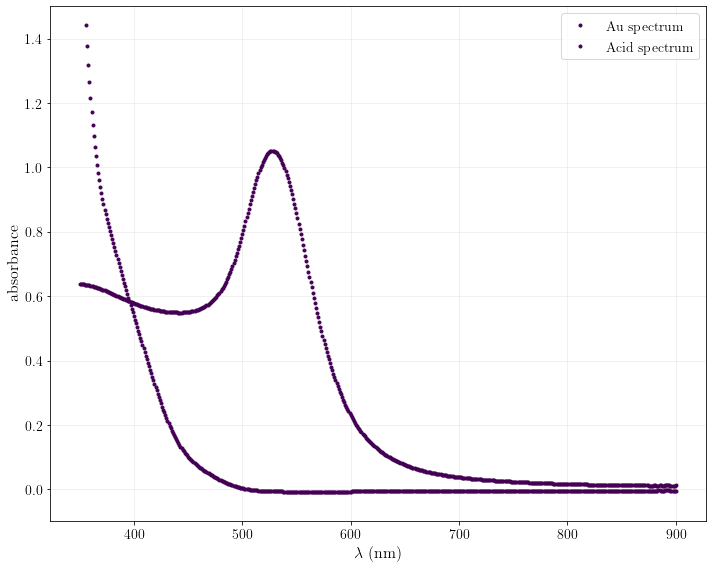

In [26]:
# Plot of experimental results
fig, (ax2) = plt.subplots(1, 1, figsize=(10,8))

ax2.plot(np_data['lam(nm)'],np_data['abs'],'.',color='#440154',label='Au spectrum')
#ax2.set_title(r'Plot of absorbtion as a function of the wavelength',fontsize=16)
ax2.plot(acid_data['lam(nm)'],acid_data['abs'],'.',color='#440154',label='Acid spectrum')
ax2.set_xlabel(r'$\lambda$ (nm)',fontsize=16)
ax2.set_ylabel(r'absorbance',fontsize=16)
ax2.grid(color='0.93')
ax2.legend(fontsize=14,title_fontsize=16,loc='upper right')
ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)
ax2.set_ylim(-0.1,1.50)

if not os.path.isdir('./data1/images'):
        os.mkdir('./data1/images')
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('data1/images/exp_data.pdf', format='pdf')

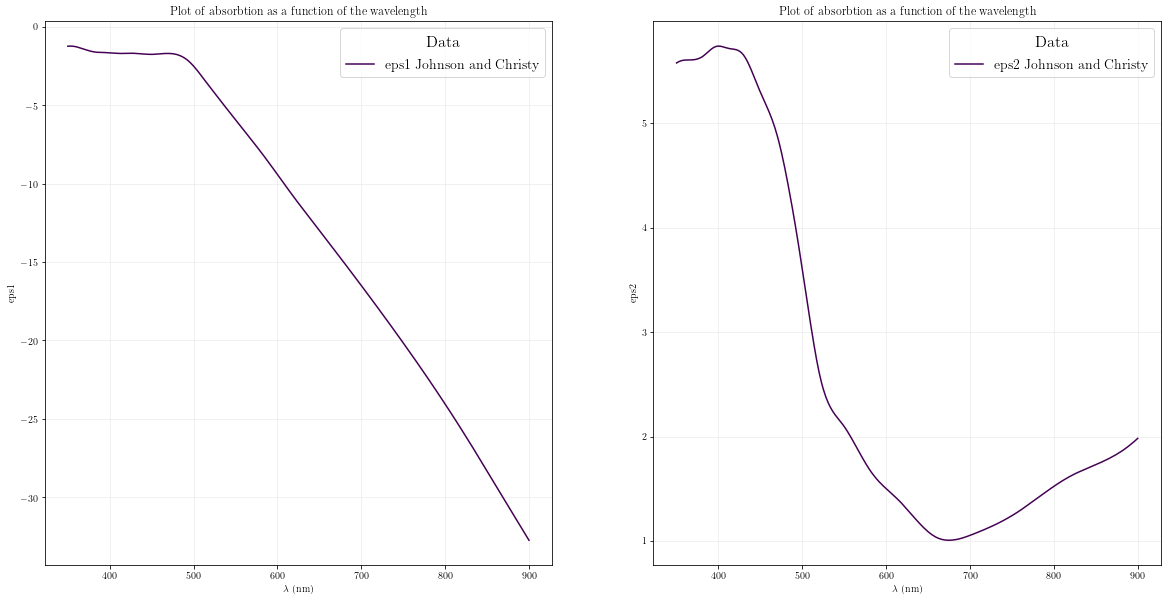

In [6]:
# Plot of eps1 and eps2 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.plot(np_data['lam(nm)'],np_data['eps1'],'',color='#440154',label='eps1 Johnson and Christy')
ax1.set_title(r'Plot of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('eps1')
ax1.grid(color='0.93')
ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='upper right')

ax2.plot(np_data['lam(nm)'],np_data['eps2'],'',color='#440154',label='eps2 Johnson and Christy')
ax2.set_title('Plot of absorbtion as a function of the wavelength')
ax2.set_xlabel('$\lambda$ (nm)')
ax2.set_ylabel('eps2')
ax2.grid(color='0.93')
ax2.legend(title='Data',fontsize=14,title_fontsize=16,loc='upper right')


### Size correction for the dielectric function

In [12]:
# CONSTANTS
e          = 1.6 * np.power(1/10,19)  # Electron charge
n          = 5.90 * np.power(10.,28)   # Density of free electrons in Au
eps0       = 8.85 * np.power(1/10,12) # Dielectric function of void
me         = 9.11 * np.power(1/10,31) # Mass electron
m0         = 0.99                     # Efficancy mass

hbar       = 6.58 * np.power(1/10,16)
c_speed    = 3. * np.power(10.,8) * np.power(10,9)    # speed of light [nm/s]

omega_p    = np.sqrt( n*e*e/(m0*me*eps0) )                        # plasmon frequency [Hz]

gamma_bulk = 1/(9.3*np.power(1/10,15))                            # gamma bulk [Hz]
v_f        = 1.4 * np.power(10.,6) * np.power(10.,9)  # Fermi velocity 

print('omega p   :', omega_p)
print('gamma bulk:', gamma_bulk)


omega p   : 1.3756171048718256e+16
gamma bulk: 107526881720430.02


In [13]:
# Define the function gamma_R
def gamma_R(R):
    return gamma_bulk + np.pi/4 * v_f * 1/R

# Function correction of size to the dielectric function
# eps1
def eps_1_corr(eps1,omega,R):
    eps_1_corr = eps1 + np.power(omega_p,2) * (  1/( np.power(omega,2) + np.power(gamma_bulk,2) ) 
                                               - 1/( np.power(omega,2) + np.power(gamma_R(R),2) )  )
    return eps_1_corr
# eps2
def eps_2_corr(eps2,omega,R):
    eps_2_corr = eps2 - np.power(omega_p,2)/omega  * (  gamma_bulk/( np.power(omega,2) + np.power(gamma_bulk,2) ) 
                                                      - gamma_R(R)/( np.power(omega,2) + np.power(gamma_R(R),2) )  )
    return eps_2_corr


##### Check size correction

Er value in 1: 0.7942614762937731


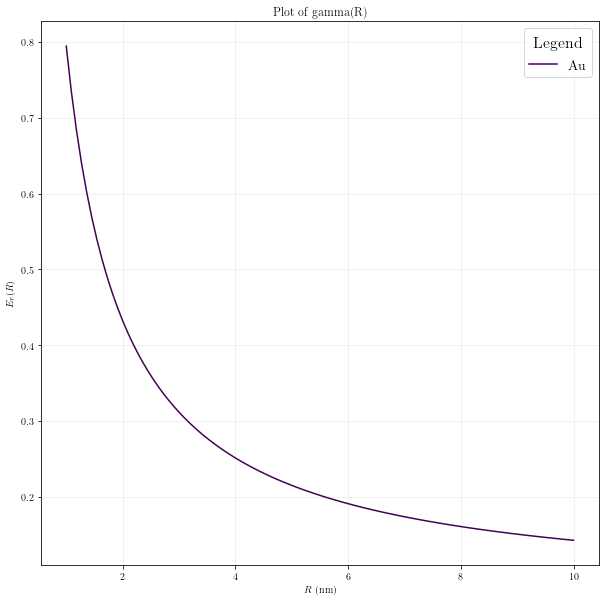

In [14]:
# Compute values of gamma (R)
R_gamma = np.linspace(1,10,100)
gamma_R_list = [ 6.58 * np.power(1/10,16) * gamma_R(r) for r in R_gamma]

# Gamma (R)

fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))

col = palette.viridis(len(R_gamma)+1)

ax1.plot(R_gamma,gamma_R_list,'',color=col[0],label='Au')

ax1.set_title('Plot of gamma(R)')
ax1.set_xlabel('$R$ (nm)')
ax1.set_ylabel('$E_r(R)$')
ax1.grid(color='0.93')
ax1.legend(title='Legend',fontsize=14,title_fontsize=16,loc='upper right')

print('Er value in 1:',gamma_R_list[0])

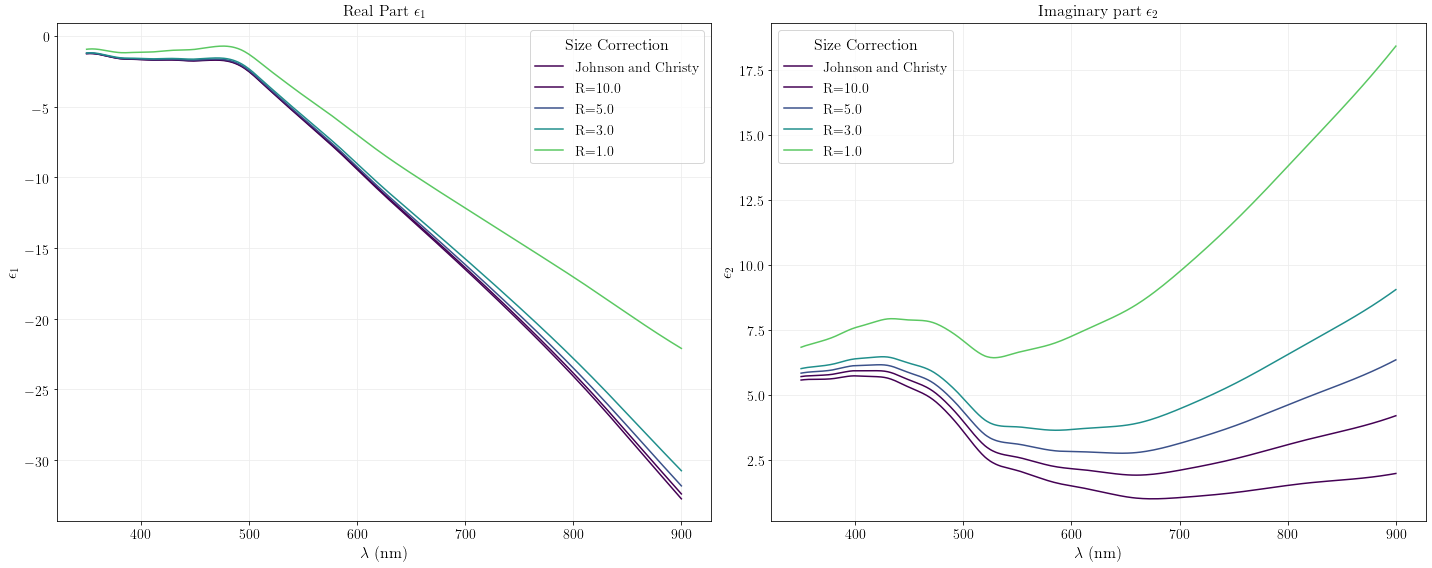

In [15]:
# Compute values of eps1 and eps2 corrected
x     = np.array( np_data['lam(nm)'] ) 
eps_1 = np.array( np_data['eps1'] )
eps_2 = np.array( np_data['eps2'] )

omega = 2 * np.pi * c_speed / x


R         = [10,5,3,1]
eps1_list = []
eps2_list = []

for i in R:
    eps1_list.append( eps_1_corr(eps_1,omega,i) )
    eps2_list.append( eps_2_corr(eps_2,omega,i) )
    
# Plot of eps1 and eps2 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

col = palette.viridis(len(R)+1)

ax1.plot(np_data['lam(nm)'],np_data['eps1'],'',color=col[0],label='Johnson and Christy')

for i in range(len(R)):
    ax1.plot(np_data['lam(nm)'],eps1_list[i],'',color=col[i],label='R={0:2.1f}'.format(R[i]))

ax1.set_title(r'Real Part $\epsilon_1$',fontsize=16)
ax1.set_xlabel(r'$\lambda$ (nm)',fontsize=16)
ax1.set_ylabel(r'$\epsilon_1$',fontsize=16)
ax1.grid(color='0.93')
ax1.legend(title='Size Correction',fontsize=14,title_fontsize=16,loc='upper right')
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)

ax2.plot(np_data['lam(nm)'],np_data['eps2'],'',color=col[0],label='Johnson and Christy')

for i in range(len(R)):
    ax2.plot(np_data['lam(nm)'],eps2_list[i],'',color=col[i],label='R={0:2.1f}'.format(R[i]))

ax2.set_title(r'Imaginary part $\epsilon_2$',fontsize=16)
ax2.set_xlabel(r'$\lambda$ (nm)',fontsize=16)
ax2.set_ylabel(r'$\epsilon_2$',fontsize=16)
ax2.grid(color='0.93')
ax2.legend(title='Size Correction',fontsize=14,title_fontsize=16,loc='best')
ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)


if not os.path.isdir('./data1/images'):
        os.mkdir('./data1/images')
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('data1/images/size_correction.pdf', format='pdf')


### FIT LOG NORMAL

In [16]:
# Limit the fit range 
np_data_f = np_data[np_data['lam(nm)']>= 420]  
np_data_f = np_data_f[np_data_f['lam(nm)']<= 650]

#### R and Rho

1.0

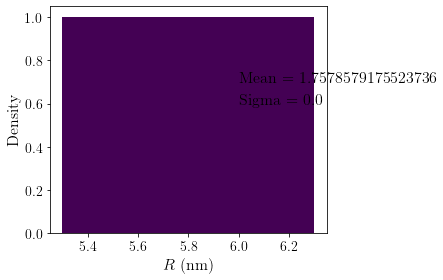

In [24]:
np.random.seed(20)
#mu, sigma = 4.9, 0.1 # mean and standard deviation
sigma = 0.
mu    = np.log(5.8) - sigma**2/2 # mean and standard deviation
s = np.random.lognormal(mu, sigma, 1000)


count, bins, ignored = plt.hist(s, 1, density=True, align='mid',color='#440154')

plt.xlabel('$R$ (nm)',fontsize=16)
plt.ylabel('Density',fontsize=16)

plt.tick_params(axis="x", labelsize=14)
plt.tick_params(axis="y", labelsize=14)

plt.text(6., 0.7, r'Mean  = {0:}'.format(mu), fontsize=16)
plt.text(6., 0.6, r'Sigma = {0:}'.format(sigma), fontsize=16)

if not os.path.isdir('./data1/images'):
        os.mkdir('./data1/images')
        
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('data1/images/size_distribution.pdf', format='pdf')




bins_centers = (bins[1:]+bins[:-1])/2 # bincenters
binwidth = (bins[1:]-bins[:-1])

sigma = [0]*len(bins_centers)

for i in range(len(bins_centers)):
    sigma[i] = count[i]*np.power(bins_centers[i],3)  
    
sum(count*binwidth)

In [25]:

bins_centers

array([5.8])

In [13]:
#Define the function for the fit R and rho
def cross_section_rho(x,a,b):  # a = R, b=rho
    
    omega = 2 * np.pi * c_speed / x
    
    epsm = 1.33*1.33 
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    constant = np.log10(np.e) * 9/c_speed * 4/3 * np.pi * np.power(10.,7) * np.power(epsm,3/2) * np.power(1/10,9) # L'ultimo valore è in piùùùù
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    eps_1 = np.array( np_data_f['eps1'] )
    eps_2 = np.array( np_data_f['eps2'] )

    np.random.seed(420)
    mu, sigma = a, 0.1 # mean and standard deviation
    s = np.random.lognormal(np.log(mu), sigma, 1000)
    count, bins = np.histogram(s,bins=30,density=True)
    bins_centers = (bins[1:]+bins[:-1])/2 # find bincenters
    binwidth = (bins[1:]-bins[:-1])  
    
    absorbance = [0]*len(bins_centers)
    
    for i in range(len(bins_centers)):
        eps1 = eps_1_corr(eps_1,omega,bins_centers[i])
        eps2 = eps_2_corr(eps_2,omega,bins_centers[i])
        absorbance[i] = count[i] * constant * np.power(bins_centers[i],3) * b * omega * np.divide(eps2, np.power(eps1+2*epsm,2) + np.power(eps2,2) )
    
    absorbance = sum(absorbance)
    
    return absorbance


In [14]:
R_list = np.linspace(4, 7, num=100)
rho_list = np.linspace(0.1,10, num=100)

x = np.array( np_data_f['lam(nm)'] )
y = np.array( np_data_f['abs'] )

error = 1/y

chi_list = [] 
a_list   = []
b_list   = []


for i in range(len(R_list)):
    for j in range(len(rho_list)):
        chisq = np.sum( np.power( y - cross_section_rho(x,R_list[i],rho_list[j]), 2)/(np.power(error,2)) )
        
        chi_list.append(chisq)
        a_list.append(R_list[i])
        b_list.append(rho_list[j])

        
min_chi       =  min(chi_list)
index_min_chi = np.argmin(chi_list)
a             = a_list[index_min_chi]
b             = b_list[index_min_chi]

print('min chi_square:', min_chi)
print('index min chi_square index:', index_min_chi)
print('a=',a)
print('b=',b)


min chi_square: 0.48973336027741404
index min chi_square index: 508
a= 4.151515151515151
b= 0.9


posx and posy should be finite values
posx and posy should be finite values


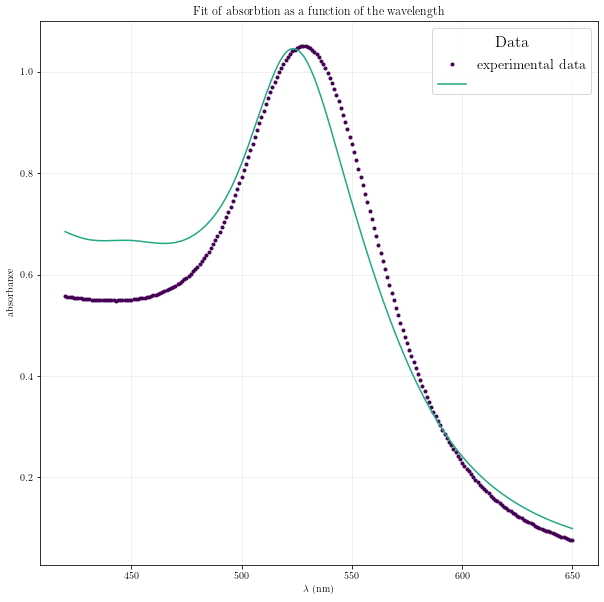

In [15]:
# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))

ax1.plot(x,y,'.',color=palette.viridis(6)[0], label= 'experimental data')
ax1.plot(x,cross_section_rho(x,a,b),'',color=palette.viridis(6)[3], label=' \n Cross-section fit \n a={0:01.4f}, b={1:01.4f}'.format(a,b))

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='upper left')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='upper right')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')

posx and posy should be finite values
posx and posy should be finite values


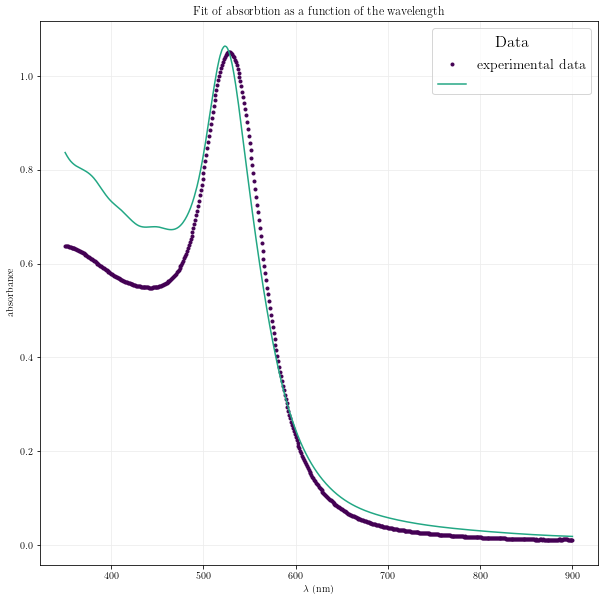

In [16]:
def cross_section_rho_plot(x,a,b):  # a = R, b=rho
    
    omega = 2 * np.pi * c_speed / x
    
    epsm = 1.33*1.33 
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    constant = np.log10(np.e) * 9/c_speed * 4/3 * np.pi * np.power(10.,7) * np.power(epsm,3/2) * np.power(1/10,9) # L'ultimo valore è in piùùùù
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    eps_1 = np.array( np_data['eps1'] )
    eps_2 = np.array( np_data['eps2'] )

    np.random.seed(260)
    mu, sigma = a, 0.1 # mean and standard deviation
    s = np.random.lognormal(np.log(mu), sigma, 1000)
    count, bins = np.histogram(s,bins=30,density=True)
    bins_centers = (bins[1:]+bins[:-1])/2 # find bincenters
    binwidth = (bins[1:]-bins[:-1])  
    
    absorbance = [0]*len(bins_centers)
    
    for i in range(len(bins_centers)):
        eps1 = eps_1_corr(eps_1,omega,bins_centers[i])
        eps2 = eps_2_corr(eps_2,omega,bins_centers[i])
        absorbance[i] = count[i] * constant * np.power(bins_centers[i],3) * b * omega * np.divide(eps2, np.power(eps1+2*epsm,2) + np.power(eps2,2) )
    
    absorbance = sum(absorbance)
    
    #print(absorbance)
    return absorbance


## Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))
#
ax1.plot(np_data['lam(nm)'],np_data['abs'],'.',color=palette.viridis(6)[0], label= 'experimental data')
ax1.plot(np_data['lam(nm)'],cross_section_rho_plot(np_data['lam(nm)'], a,b),'',color=palette.viridis(6)[3],label=' \n Cross-section fit \n a={0:4.4f}, b={1:4.4f}'.format(a,b))

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='best')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')


#### R and epsm 

In [17]:
R = a
rho = b

min chi_square: 0.2956110727854768
index min chi_square index: 18
a= 4.0
b= 1.3636363636363635


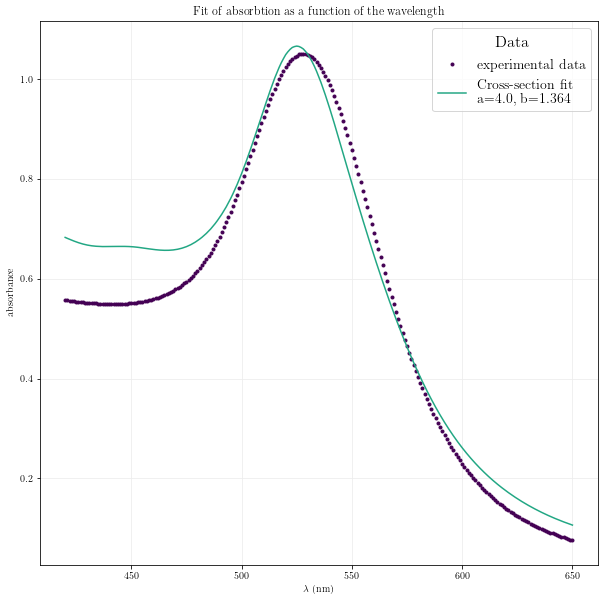

In [18]:
#Define the function for the fit R and epsm
def cross_section_epsm(x,a,b,val_rho):  # a = R, b = epsm
    
    omega = 2 * np.pi * c_speed / x
    
    rho = val_rho * np.power(1/10,9) # VALORE INSERITO IN PIUUU
    
    constant = np.log10(np.e) * 9/c_speed * 4/3 * np.pi * np.power(10,7) * rho
    
    eps_1 = np.array( np_data_f['eps1'] )
    eps_2 = np.array( np_data_f['eps2'] )
 
    np.random.seed(260)
    mu, sigma = a, 0.1 # mean and standard deviation
    s = np.random.lognormal(np.log(mu), sigma, 1000)
    count, bins = np.histogram(s,bins=30,density=True)
    bins_centers = (bins[1:]+bins[:-1])/2 # find bincenters
    binwidth = (bins[1:]-bins[:-1])  
    
    absorbance = [0]*len(bins_centers)
    
    for i in range(len(bins_centers)):    
        eps1 = eps_1_corr(eps_1,omega,bins_centers[i])
        eps2 = eps_2_corr(eps_2,omega,bins_centers[i])
    
        absorbance[i] = count[i] * constant * np.power(bins_centers[i],3)* omega * np.power((b**2),3/2) * np.divide(eps2, np.power(eps1+2*(b**2),2) + np.power(eps2,2) )
    
    absorbance = sum(absorbance)
    
    return absorbance



R_list = np.linspace(4., 6., num=100)
epsm_list = np.linspace(1.2,2.1, num=100)

x = np.array( np_data_f['lam(nm)'] )
y = np.array( np_data_f['abs'] )

error = 1/y

chi_list = [] 
a_list   = []
b_list   = []

for i in range(len(R_list)):
    for j in range(len(epsm_list)):
        chisq = np.sum( np.power( y - cross_section_epsm(x,R_list[i],epsm_list[j],rho), 2) /(np.power(error,2)) )
        
        chi_list.append(chisq)
        a_list.append(R_list[i])
        b_list.append(epsm_list[j])

        
min_chi       =  min(chi_list)
index_min_chi = np.argmin(chi_list)
a             = a_list[index_min_chi]
b             = b_list[index_min_chi]

print('min chi_square:', min_chi)
print('index min chi_square index:', index_min_chi)
print('a=',a)
print('b=',b)

# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))
#
ax1.plot(x,y,'.',color=palette.viridis(6)[0], label= 'experimental data')
string= 'Cross-section fit \n a='+str(round(a,3))+', b='+str(round(b,3))
ax1.plot(x,cross_section_epsm(x,a,b,rho),'',color=palette.viridis(6)[3], label=string)

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='best')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')



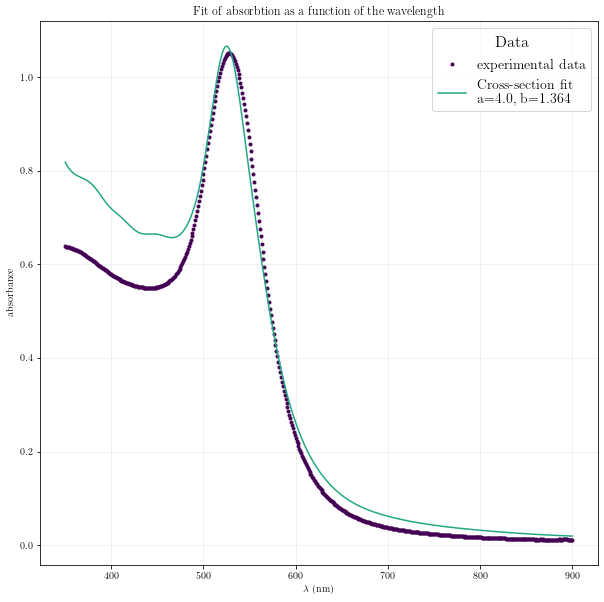

In [19]:
def cross_section_epsm_plot(x,a,b,val_rho):  # a = R, b = epsm
    
    omega = 2 * np.pi * c_speed / x
    
    rho = val_rho * np.power(1/10,9) # VALORE INSERITO IN PIUUU
    
    constant = np.log10(np.e) * 9/c_speed * 4/3 * np.pi * np.power(10,7) * rho
    
    eps_1 = np.array( np_data['eps1'] )
    eps_2 = np.array( np_data['eps2'] )
 
    np.random.seed(260)
    mu, sigma = a, 0.1 # mean and standard deviation
    s = np.random.lognormal(np.log(mu), sigma, 1000)
    count, bins = np.histogram(s,bins=30,density=True)
    bins_centers = (bins[1:]+bins[:-1])/2 # find bincenters
    binwidth = (bins[1:]-bins[:-1])  
    
    absorbance = [0]*len(bins_centers)
    
    for i in range(len(bins_centers)):    
        eps1 = eps_1_corr(eps_1,omega,bins_centers[i])
        eps2 = eps_2_corr(eps_2,omega,bins_centers[i])
    
        absorbance[i] = count[i] * constant * np.power(bins_centers[i],3)* omega * np.power((b**2),3/2) * np.divide(eps2, np.power(eps1+2*(b**2),2) + np.power(eps2,2) )
    
    absorbance = sum(absorbance)
    
    return absorbance

## Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))
#
ax1.plot(np_data['lam(nm)'],np_data['abs'],'.',color=palette.viridis(6)[0], label= 'experimental data')
string= 'Cross-section fit \n a='+str(round(a,3))+', b='+str(round(b,3))
ax1.plot(np_data['lam(nm)'],cross_section_epsm_plot(np_data['lam(nm)'], a,b,rho),'',color=palette.viridis(6)[3],label=string)

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='best')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')



### Fit

Define the function for the fit

#### Function fit

In [20]:
# Limit the fit range 
np_data_f = np_data[np_data['lam(nm)']>= 420]  
np_data_f = np_data_f[np_data_f['lam(nm)']<= 650]

In [21]:
#Define the function for the fit R and rho
def cross_section_rho(x,a,b):  # a = R, b=rho
    
    omega = 2 * np.pi * c_speed / x
    
    epsm = 1.45*1.45 #1.33*1.33 
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    constant = np.log10(np.e) * 9/c_speed * 4/3 * np.pi * np.power(10.,7) * np.power(epsm,3/2) * np.power(1/10,9) # L'ultimo valore è in piùùùù
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    eps_1 = np.array( np_data_f['eps1'] )
    eps_2 = np.array( np_data_f['eps2'] )
    
    eps1 = eps_1_corr(eps_1,omega,a)
    eps2 = eps_2_corr(eps_2,omega,a)
    
    sigma = constant * np.power(a,3) * b * omega * np.divide(eps2, np.power(eps1+2*epsm,2) + np.power(eps2,2) )
    
    return sigma

#Define the function for the fit R and epsm
def cross_section_epsm(x,a,b,val_rho):  # a = R, b = epsm
    
    omega = 2 * np.pi * c_speed / x
    
    rho = val_rho * np.power(1/10,9) # VALORE INSERITO IN PIUUU
    
    constant = np.log10(np.e) * 9/c_speed * 4/3 * np.pi * np.power(10,7) * rho
    
    eps_1 = np.array( np_data_f['eps1'] )
    eps_2 = np.array( np_data_f['eps2'] )
    
    eps1 = eps_1_corr(eps_1,omega,a)
    eps2 = eps_2_corr(eps_2,omega,a)
    
    sigma = constant * np.power(a,3)* omega * np.power((b**2),3/2) * np.divide(eps2, np.power(eps1+2*(b**2),2) + np.power(eps2,2) )
    
    return sigma

def cross_section_tutto(x,a,b,epsm):  # a = R, b=rho, epsm=epsm
    
    omega = 2 * np.pi * c_speed / x

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    constant = np.log10(np.e) * 9/c_speed * 4/3 * np.pi * np.power(10.,7) * np.power((epsm**2),3/2) * np.power(1/10,9) # L'ultimo valore è in piùùùù
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    eps_1 = np.array( np_data_f['eps1'] )
    eps_2 = np.array( np_data_f['eps2'] )
    
    
    ##############################################
    np.random.seed(420)
    mu, sigma = a, 0.1 # mean and standard deviation
    s = np.random.lognormal(np.log(mu), sigma, 1000)
    count, bins = np.histogram(s,bins=30,density=True)
    bins_centers = (bins[1:]+bins[:-1])/2 # find bincenters
    binwidth = (bins[1:]-bins[:-1])  
    
    absorbance = [0]*len(bins_centers)
    
    for i in range(len(bins_centers)):
        eps1 = eps_1_corr(eps_1,omega,bins_centers[i])
        eps2 = eps_2_corr(eps_2,omega,bins_centers[i])
        absorbance[i] = count[i] * constant * np.power(bins_centers[i],3) * b * omega * np.divide(eps2, np.power(eps1+2*(epsm**2),2) + np.power(eps2,2) )
    
    absorbance = sum(absorbance)
    
    return absorbance

    ##########
    #eps1 = eps_1_corr(eps_1,omega,a)
    #eps2 = eps_2_corr(eps_2,omega,a)
    #
    #sigma = constant * np.power(a,3) * b * omega * np.divide(eps2, np.power(eps1+2*(epsm**2),2) + np.power(eps2,2) )
    
    #return sigma


#### Fit with python function R, Rho and Epsm

posx and posy should be finite values
posx and posy should be finite values


a= 5.98768734001492 

b= 0.31209724184570786 

epsm= 1.4404816424624973 

Chi square: 0.09716791251812844


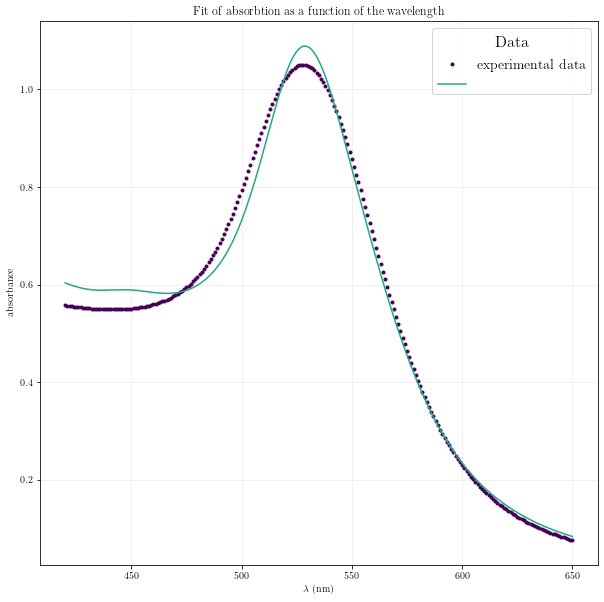

In [22]:
x = np.array( np_data_f['lam(nm)'] )
y = np.array( np_data_f['abs'] )

error = 1/y

# Bound R and rho
## Fit

popt, pcov = curve_fit(cross_section_tutto, x, y, p0=[5.4,3,1.8],bounds=([4,0.01,1.2],[8,3,3])  )

a = popt[0]
b = popt[1]
epsm = popt[2]

print('a=',a,'\n')
print('b=',b,'\n')
print('epsm=',epsm,'\n')

# Compute chi squared
chisq = np.sum( np.power( y - cross_section_tutto(x,a,b,epsm),2)/(np.power(error,2)) )

print('Chi square:', chisq)


## Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))
#
ax1.plot(x,y,'.',color=palette.viridis(6)[0], label= 'experimental data')
ax1.plot(x,cross_section_tutto(x, *popt),'',color=palette.viridis(6)[3], label=' \n Cross-section fit \n a={0:4.4f}, b={1:4.4f}, n={2:4.4f}'.format(a,b,epsm))

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='best')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')


posx and posy should be finite values
posx and posy should be finite values


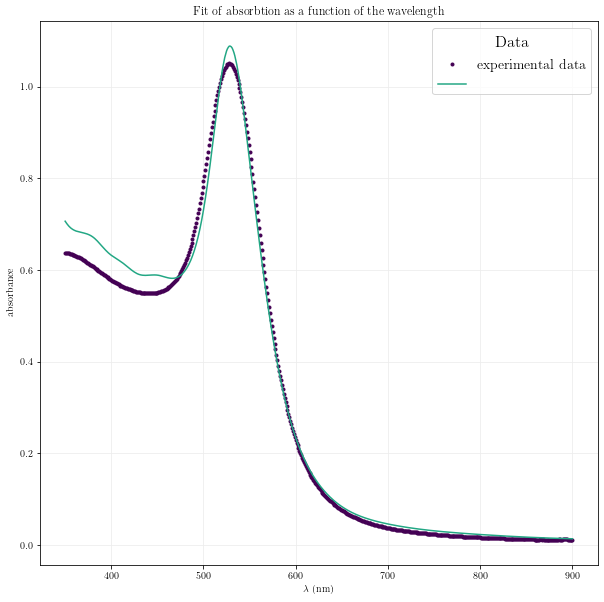

In [23]:
#def cross_section_tutto_plot(x,a,b,epsm):  # a = R, b=rho, epsm=epsm
#    
#    omega = 2 * np.pi * c_speed / x
#
#    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#    constant = np.log10(np.e) * 9/c_speed * 4/3 * np.pi * np.power(10.,7) * np.power((epsm**2),3/2) * np.power(1/10,9) # L'ultimo valore è in piùùùù
#    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#    
#    eps_1 = np.array( np_data['eps1'] )
#    eps_2 = np.array( np_data['eps2'] )
#    
#    eps1 = eps_1_corr(eps_1,omega,a)
#    eps2 = eps_2_corr(eps_2,omega,a)
#    
#    sigma = constant * np.power(a,3) * b * omega * np.divide(eps2, np.power(eps1+2*(epsm**2),2) + np.power(eps2,2) )
#    
#    return sigma

def cross_section_tutto_plot(x,a,b,epsm):  # a = R, b=rho, epsm=epsm
    
    omega = 2 * np.pi * c_speed / x

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    constant = np.log10(np.e) * 9/c_speed * 4/3 * np.pi * np.power(10.,7) * np.power((epsm**2),3/2) * np.power(1/10,9) # L'ultimo valore è in piùùùù
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    eps_1 = np.array( np_data['eps1'] )
    eps_2 = np.array( np_data['eps2'] )
    
    
    ##############################################
    np.random.seed(420)
    mu, sigma = a, 0.1 # mean and standard deviation
    s = np.random.lognormal(np.log(mu), sigma, 1000)
    count, bins = np.histogram(s,bins=30,density=True)
    bins_centers = (bins[1:]+bins[:-1])/2 # find bincenters
    binwidth = (bins[1:]-bins[:-1])  
    
    absorbance = [0]*len(bins_centers)
    
    for i in range(len(bins_centers)):
        eps1 = eps_1_corr(eps_1,omega,bins_centers[i])
        eps2 = eps_2_corr(eps_2,omega,bins_centers[i])
        absorbance[i] = count[i] * constant * np.power(bins_centers[i],3) * b * omega * np.divide(eps2, np.power(eps1+2*(epsm**2),2) + np.power(eps2,2) )
    
    absorbance = sum(absorbance)
    
    return absorbance

    ##########
    #eps1 = eps_1_corr(eps_1,omega,a)
    #eps2 = eps_2_corr(eps_2,omega,a)
    #
    #sigma = constant * np.power(a,3) * b * omega * np.divide(eps2, np.power(eps1+2*(epsm**2),2) + np.power(eps2,2) )
    
    #return sigma
    
    
## Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))
#
ax1.plot(np_data['lam(nm)'],np_data['abs'],'.',color=palette.viridis(6)[0], label= 'experimental data')
ax1.plot(np_data['lam(nm)'],cross_section_tutto_plot(np_data['lam(nm)'], a,b,epsm),'',color=palette.viridis(6)[3],label=' \n Cross-section fit \n a={0:4.4f}, b={1:4.4f}, n={2:4.4f}'.format(a,b,epsm))

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='best')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')


#### For loop R and Rho

posx and posy should be finite values
posx and posy should be finite values


min chi_square: 0.10433831418239836
index min chi_square index: 6525
a= 5.626262626262626
b= 3.272727272727273


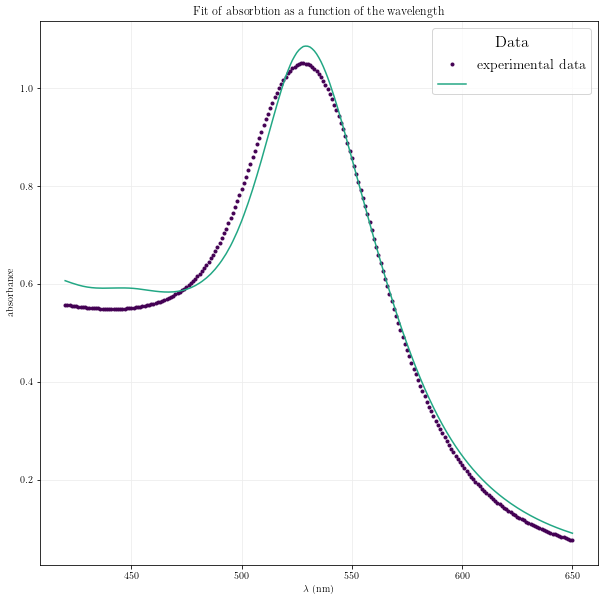

In [24]:
R_list = np.linspace(3, 7, num=100)
rho_list = np.linspace(1,10, num=100)

x = np.array( np_data_f['lam(nm)'] )
y = np.array( np_data_f['abs'] )

error = 1/y

chi_list = [] 
a_list   = []
b_list   = []


for i in range(len(R_list)):
    for j in range(len(rho_list)):
        chisq = np.sum( np.power( y - cross_section_rho(x,R_list[i],rho_list[j]), 2)  /(np.power(error,2)) )
        
        chi_list.append(chisq)
        a_list.append(R_list[i])
        b_list.append(rho_list[j])

        
min_chi       =  min(chi_list)
index_min_chi = np.argmin(chi_list)
a             = a_list[index_min_chi]
b             = b_list[index_min_chi]

print('min chi_square:', min_chi)
print('index min chi_square index:', index_min_chi)
print('a=',a)
print('b=',b)

# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))

ax1.plot(x,y,'.',color=palette.viridis(6)[0], label= 'experimental data')
ax1.plot(x,cross_section_rho(x,a,b),'',color=palette.viridis(6)[3], label=' \n Cross-section fit \n a={0:01.4f}, b={1:01.4f}'.format(a,b))

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='upper left')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='upper right')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')


posx and posy should be finite values
posx and posy should be finite values


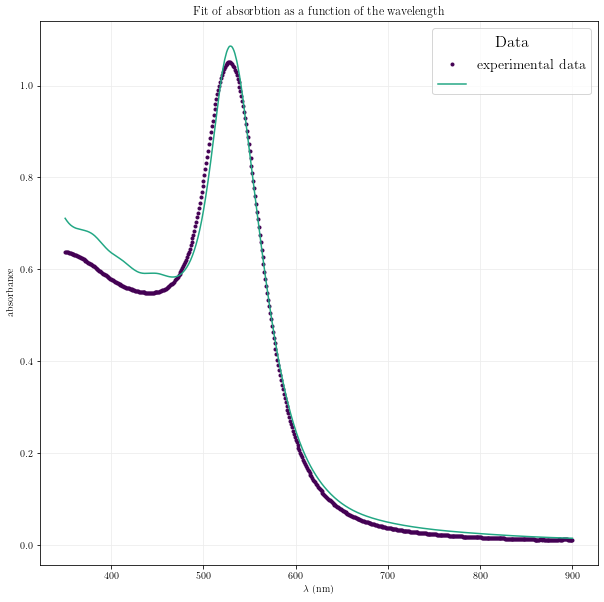

In [25]:
def cross_section_rho_plot(x,a,b):  # a = R, b=rho
    
    omega = 2 * np.pi * c_speed / x
    
    epsm = 1.45*1.45#1.33*1.33 
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    constant = np.log10(np.e) * 9/c_speed * 4/3 * np.pi * np.power(10.,7) * np.power(epsm,3/2) * np.power(1/10,9) # L'ultimo valore è in piùùùù
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    eps_1 = np.array( np_data['eps1'] )
    eps_2 = np.array( np_data['eps2'] )
    
    eps1 = eps_1_corr(eps_1,omega,a)
    eps2 = eps_2_corr(eps_2,omega,a)
    
    sigma = constant * np.power(a,3) * b * omega * np.divide(eps2, np.power(eps1+2*epsm,2) + np.power(eps2,2) )
    
    return sigma

## Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))
#
ax1.plot(np_data['lam(nm)'],np_data['abs'],'.',color=palette.viridis(6)[0], label= 'experimental data')
ax1.plot(np_data['lam(nm)'],cross_section_rho_plot(np_data['lam(nm)'], a,b),'',color=palette.viridis(6)[3],label=' \n Cross-section fit \n a={0:4.4f}, b={1:4.4f}'.format(a,b))

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='best')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')


In [26]:
A_grid, B_grid = np.meshgrid(R_list, rho_list)

chisq_values = np.zeros((len(A_grid),len(B_grid)))

for i in range(len(A_grid)):
    for j in range(len(B_grid)):
        chisq = np.sum( np.power( y - cross_section_rho(x,A_grid[i][j],B_grid[i][j]), 2)/(np.power(error,2)) )
        if(chisq>10):
            chisq=10
        chisq_values[i][j] = chisq
        

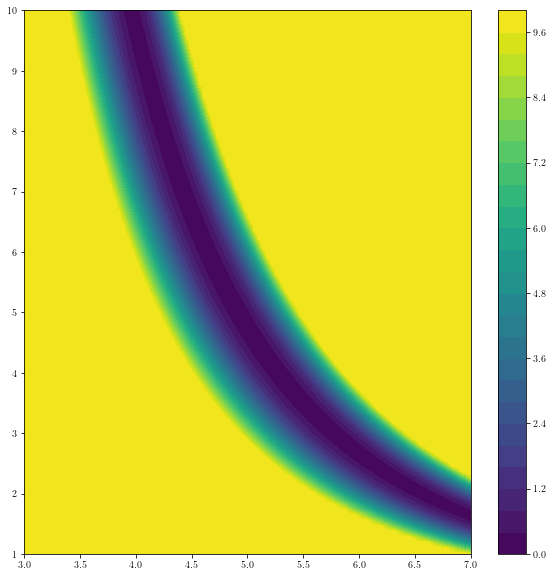

In [27]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))
cp = ax1.contourf(np.array(A_grid),np.array(B_grid),chisq_values, levels=30,cmap='viridis')

#norm=colors.LogNorm(vmin=chisq_values.min(), vmax=chisq_values.max())
#ax1.set_yscale('log')
plt.colorbar(cp)
plt.show()

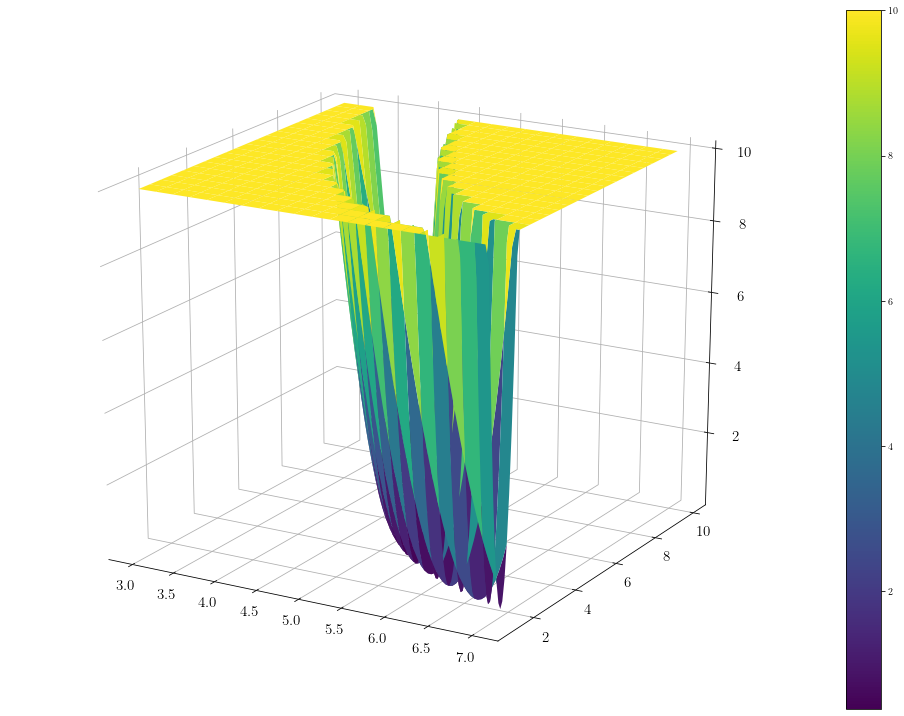

In [28]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(111, projection='3d')

cp = ax1.plot_surface(np.array(A_grid), np.array(B_grid), chisq_values,cmap='viridis'
                     , rstride=5, cstride=5)

#ax1.set_xlabel('$R$',fontsize=20,labelpad=10)
#ax1.set_ylabel('$\rho$',fontsize=20,labelpad=15)
#ax1.set_zlabel('$\chi^2$',fontsize=20,labelpad=10)

ax1.tick_params(labelsize=15)
ax1.tick_params(axis='z', which='major',labelsize=15, pad=11)
ax1.grid(linewidth=2)
ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
plt.tight_layout(h_pad=0.1)
#ax1.grid(False)
ax1.view_init(20,)
plt.colorbar(cp)
plt.show()

In [29]:
R = a
rho = b

#### For loop R and epsm

min chi_square: 0.09021701297605582
index min chi_square index: 5536
a= 5.666666666666667
b= 1.4363636363636365


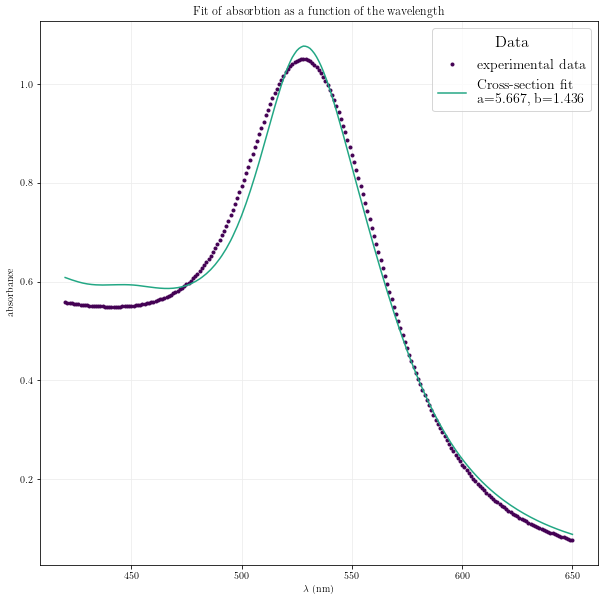

In [30]:
R_list = np.linspace(4., 7., num=100)
epsm_list = np.linspace(1.,2.2, num=100)

x = np.array( np_data_f['lam(nm)'] )
y = np.array( np_data_f['abs'] )

error = 1/y

chi_list = [] 
a_list   = []
b_list   = []

for i in range(len(R_list)):
    for j in range(len(epsm_list)):
        chisq = np.sum( np.power( y - cross_section_epsm(x,R_list[i],epsm_list[j],rho), 2) /(np.power(error,2)) )
        
        chi_list.append(chisq)
        a_list.append(R_list[i])
        b_list.append(epsm_list[j])

        
min_chi       =  min(chi_list)
index_min_chi = np.argmin(chi_list)
a             = a_list[index_min_chi]
b             = b_list[index_min_chi]

print('min chi_square:', min_chi)
print('index min chi_square index:', index_min_chi)
print('a=',a)
print('b=',b)

# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))
#
ax1.plot(x,y,'.',color=palette.viridis(6)[0], label= 'experimental data')
string= 'Cross-section fit \n a='+str(round(a,3))+', b='+str(round(b,3))
ax1.plot(x,cross_section_epsm(x,a,b,rho),'',color=palette.viridis(6)[3], label=string)

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='best')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')


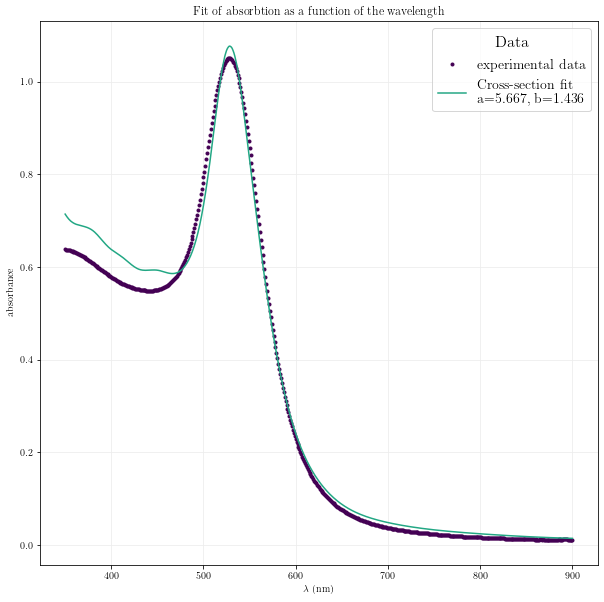

In [31]:
def cross_section_epsm_plot(x,a,b,val_rho):  # a = R, b = epsm
    
    omega = 2 * np.pi * c_speed / x
    
    rho = val_rho * np.power(1/10,9) # VALORE INSERITO IN PIUUU
    
    constant = np.log10(np.e) * 9/c_speed * 4/3 * np.pi * np.power(10,7) * rho
    
    eps_1 = np.array( np_data['eps1'] )
    eps_2 = np.array( np_data['eps2'] )
    
    eps1 = eps_1_corr(eps_1,omega,a)
    eps2 = eps_2_corr(eps_2,omega,a)
    
    sigma = constant * np.power(a,3)* omega * np.power((b**2),3/2) * np.divide(eps2, np.power(eps1+2*(b**2),2) + np.power(eps2,2) )
    
    return sigma

## Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))
#
ax1.plot(np_data['lam(nm)'],np_data['abs'],'.',color=palette.viridis(6)[0], label= 'experimental data')
string= 'Cross-section fit \n a='+str(round(a,3))+', b='+str(round(b,3))
ax1.plot(np_data['lam(nm)'],cross_section_epsm_plot(np_data['lam(nm)'], a,b,rho),'',color=palette.viridis(6)[3],label=string)

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='best')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')


In [32]:
A_grid, B_grid = np.meshgrid(R_list, epsm_list)

chisq_values = np.zeros((len(A_grid),len(B_grid)))

for i in range(len(A_grid)):
    for j in range(len(B_grid)):
        chisq = np.sum( np.power( y - cross_section_epsm(x,A_grid[i][j],B_grid[i][j],rho), 2)/(np.power(error,2)) )
        if(chisq>10):
            chisq=10
        chisq_values[i][j] = chisq
        

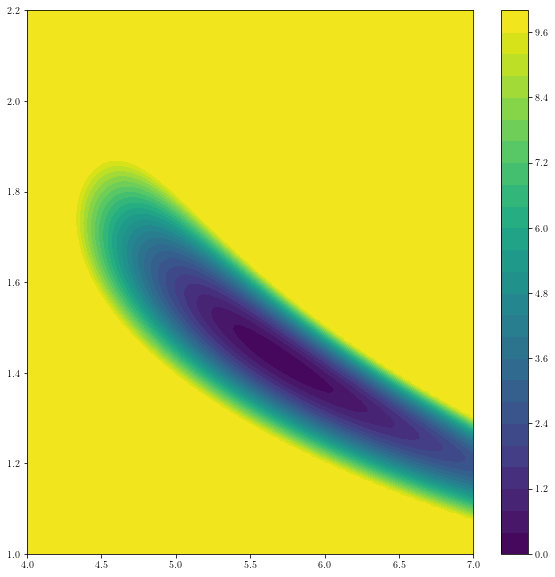

In [33]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))
cp = ax1.contourf(np.array(A_grid),np.array(B_grid),chisq_values, levels=30,cmap='viridis')

#norm=colors.LogNorm(vmin=chisq_values.min(), vmax=chisq_values.max())
#ax1.set_yscale('log')
plt.colorbar(cp)
plt.show()

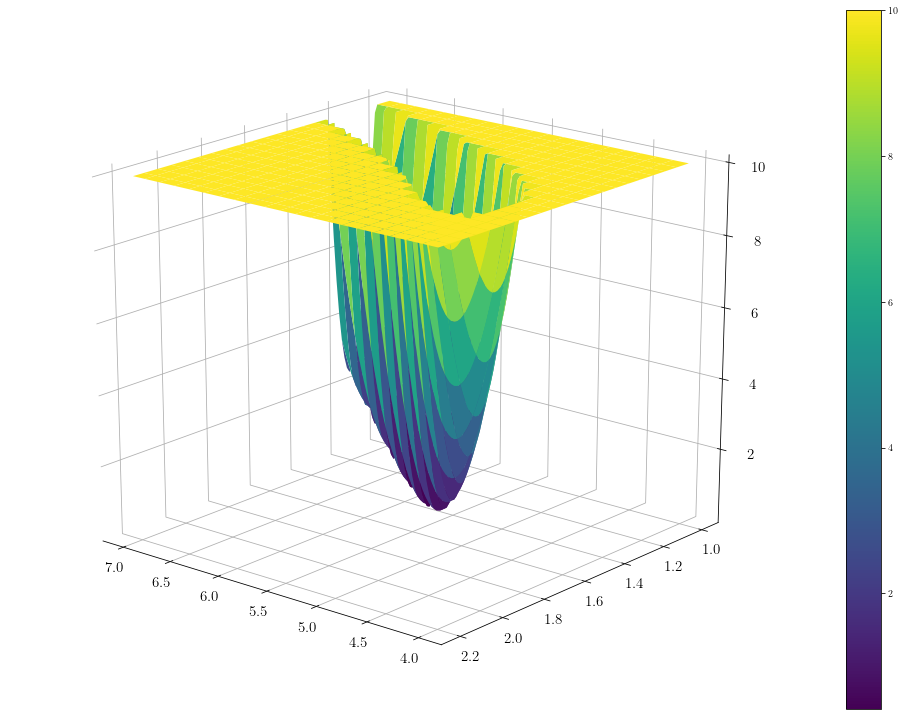

In [34]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(111, projection='3d')

cp = ax1.plot_surface(np.array(A_grid), np.array(B_grid), chisq_values,cmap='viridis'
                     , rstride=5, cstride=5)

#ax1.set_xlabel('$R$',fontsize=20,labelpad=10)
#ax1.set_ylabel('$\rho$',fontsize=20,labelpad=15)
#ax1.set_zlabel('$\chi^2$',fontsize=20,labelpad=10)

ax1.tick_params(labelsize=15)
ax1.tick_params(axis='z', which='major',labelsize=15, pad=11)
ax1.grid(linewidth=2)
ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
plt.tight_layout(h_pad=0.1)
#ax1.grid(False)
ax1.view_init(20,130)
plt.colorbar(cp)
plt.show()


In [35]:
R = a
epsm = b

#### For loop R and rho

min chi_square: 2.0896675331715264
index min chi_square index: 3399
a= 5.0
b= 9.0


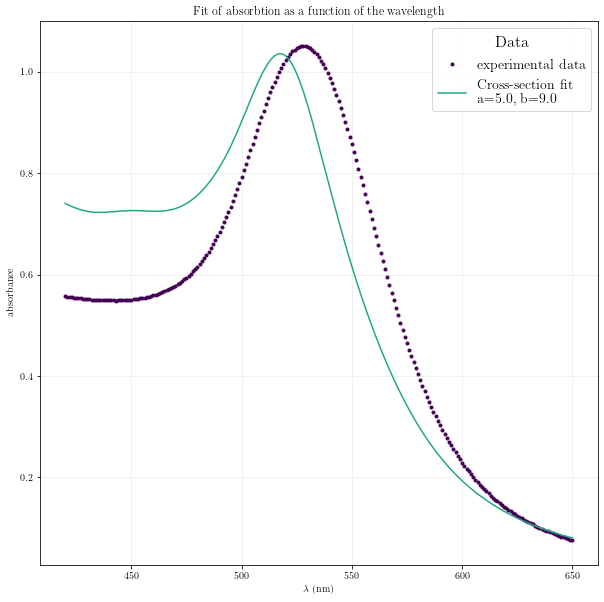

In [36]:
def cross_section_rho_epsm(x,a,b,val_epsm):  # a = R, b=rho 
    
    omega = 2 * np.pi * c_speed / x
    
    epsm = val_epsm
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    constant = np.log10(np.e) * 9/c_speed * 4/3 * np.pi * np.power(10.,7) * np.power(epsm,3/2) * np.power(1/10,9) # L'ultimo valore è in piùùùù
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    eps_1 = np.array( np_data_f['eps1'] )
    eps_2 = np.array( np_data_f['eps2'] )
    
    eps1 = eps_1_corr(eps_1,omega,a)
    eps2 = eps_2_corr(eps_2,omega,a)
    
    sigma = constant * np.power(a,3) * b * omega * np.divide(eps2, np.power(eps1+2*epsm,2) + np.power(eps2,2) )
    
    return sigma


R_list = np.linspace(4, 7, num=100)
rho_list = np.linspace(4,9, num=100)

x = np.array( np_data_f['lam(nm)'] )
y = np.array( np_data_f['abs'] )

error = 1/y

chi_list = [] 
a_list   = []
b_list   = []


for i in range(len(R_list)):
    for j in range(len(rho_list)):
        chisq = np.sum( np.power( y - cross_section_rho_epsm(x,R_list[i],rho_list[j],epsm), 2) /(np.power(error,2)) )
        
        chi_list.append(chisq)
        a_list.append(R_list[i])
        b_list.append(rho_list[j])

        
min_chi       =  min(chi_list)
index_min_chi = np.argmin(chi_list)
a             = a_list[index_min_chi]
b             = b_list[index_min_chi]

print('min chi_square:', min_chi)
print('index min chi_square index:', index_min_chi)
print('a=',a)
print('b=',b)

# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))

ax1.plot(x,y,'.',color=palette.viridis(6)[0], label= 'experimental data')
string= 'Cross-section fit \n a='+str(round(a,3))+', b='+str(round(b,3))
ax1.plot(x,cross_section_rho_epsm(x,a,b,epsm),'',color=palette.viridis(6)[3], label=string)

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='upper left')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='upper right')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')


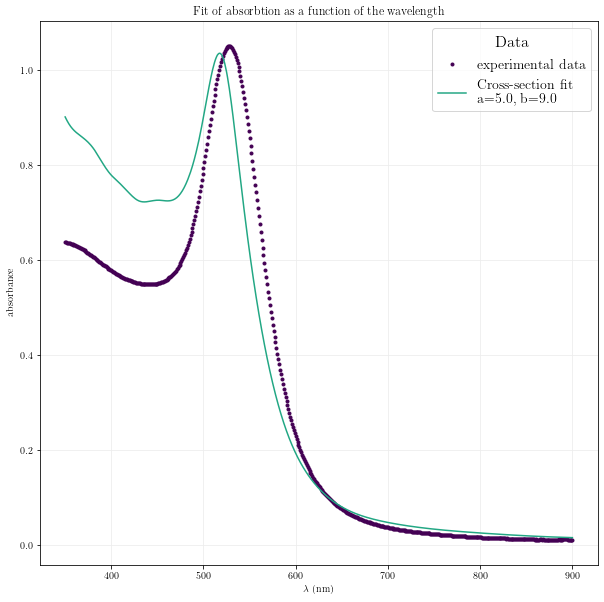

In [37]:
def cross_section_rho_epsm_plot(x,a,b,val_epsm):  # a = R, b=rho 
    
    omega = 2 * np.pi * c_speed / x
    
    epsm = val_epsm
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    constant = np.log10(np.e) * 9/c_speed * 4/3 * np.pi * np.power(10.,7) * np.power(epsm,3/2) * np.power(1/10,9) # L'ultimo valore è in piùùùù
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    eps_1 = np.array( np_data['eps1'] )
    eps_2 = np.array( np_data['eps2'] )
    
    eps1 = eps_1_corr(eps_1,omega,a)
    eps2 = eps_2_corr(eps_2,omega,a)
    
    sigma = constant * np.power(a,3) * b * omega * np.divide(eps2, np.power(eps1+2*epsm,2) + np.power(eps2,2) )
    
    return sigma

## Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))
#
ax1.plot(np_data['lam(nm)'],np_data['abs'],'.',color=palette.viridis(6)[0], label= 'experimental data')
string= 'Cross-section fit \n a='+str(round(a,3))+', b='+str(round(b,3))
ax1.plot(np_data['lam(nm)'],cross_section_rho_epsm_plot(np_data['lam(nm)'], a,b,epsm),'',color=palette.viridis(6)[3],label=string)

ax1.legend(title='Data',fontsize=14,title_fontsize=16,loc='best')
ax1.set_title('Fit of absorbtion as a function of the wavelength')
ax1.set_xlabel('$\lambda$ (nm)')
ax1.set_ylabel('absorbance')
ax1.grid(color='0.93')



In [38]:
A_grid, B_grid = np.meshgrid(R_list, rho_list)

chisq_values = np.zeros((len(A_grid),len(B_grid)))

for i in range(len(A_grid)):
    for j in range(len(B_grid)):
        chisq = np.sum( np.power( y - cross_section_rho(x,A_grid[i][j],B_grid[i][j]), 2)/(np.power(error,2)) )
        if(chisq>10):
            chisq=10
        chisq_values[i][j] = chisq
        

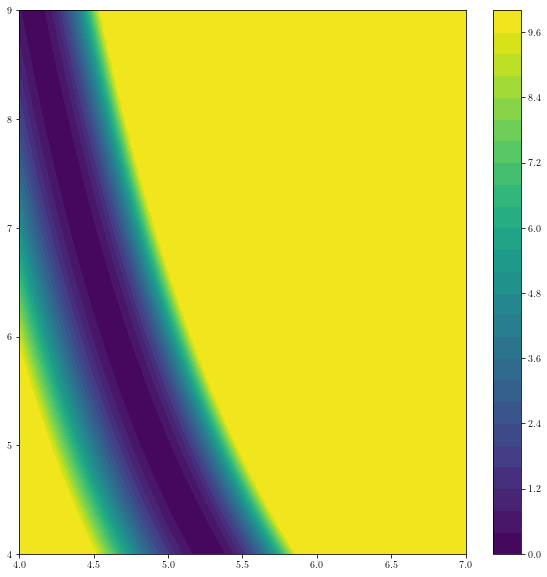

In [39]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))
cp = ax1.contourf(np.array(A_grid),np.array(B_grid),chisq_values, levels=30,cmap='viridis')

#norm=colors.LogNorm(vmin=chisq_values.min(), vmax=chisq_values.max())
#ax1.set_yscale('log')
plt.colorbar(cp)
plt.show()

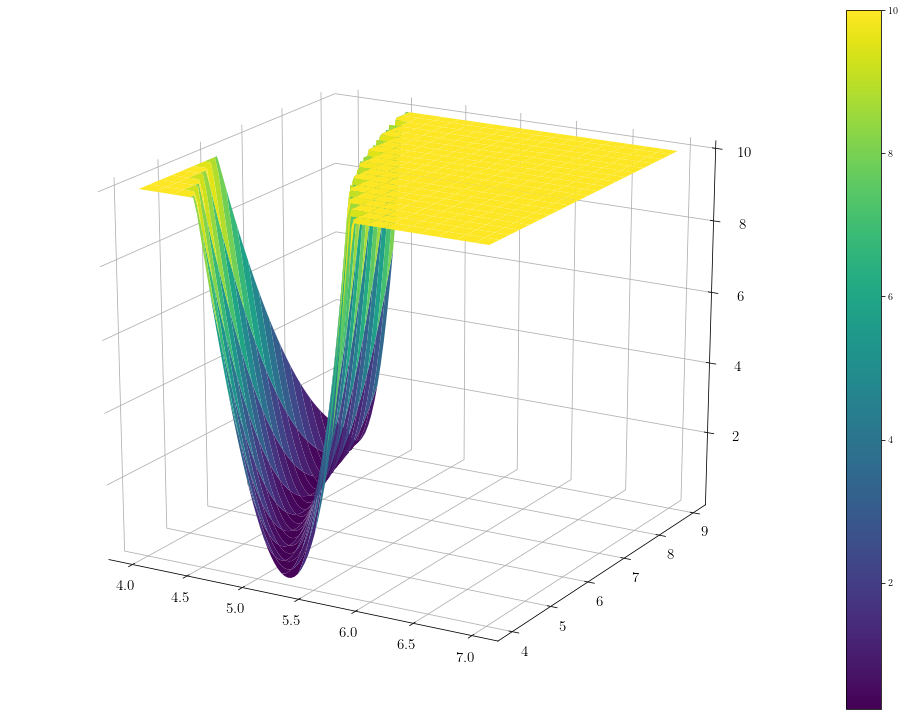

In [40]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(111, projection='3d')

cp = ax1.plot_surface(np.array(A_grid), np.array(B_grid), chisq_values,cmap='viridis'
                     , rstride=5, cstride=5)

#ax1.set_xlabel('$R$',fontsize=20,labelpad=10)
#ax1.set_ylabel('$\rho$',fontsize=20,labelpad=15)
#ax1.set_zlabel('$\chi^2$',fontsize=20,labelpad=10)

ax1.tick_params(labelsize=15)
ax1.tick_params(axis='z', which='major',labelsize=15, pad=11)
ax1.grid(linewidth=2)
ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
plt.tight_layout(h_pad=0.1)
#ax1.grid(False)
ax1.view_init(20,)
plt.colorbar(cp)
plt.show()

### Other

(-1.0, 1.0, -1.0, 2.0)

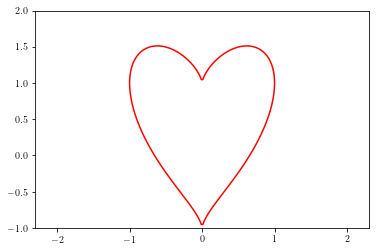

In [41]:
y, x = np.ogrid[-1:2:100j, -1:1:100j] 
plt.contour(x.ravel(), y.ravel(), x**2 + (y-((x**2)**(1.0/3)))**2, [1], colors='red',) 
plt.axis('equal') 